In [96]:
import numpy as np
import pprint
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

import util.preprocess_util as preprocess
import util.analysis_util as analysis
import util.visualise_util as visualise
from util.data_util import EEG_Dataset, get_trials, get_good_trials
from models.lda import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data from xdf file

From the Unicorn Stream
- `eeg_data`: the 8 channel raw eeg data
- `eeg_timestamps`: timestamp for each eeg sample
- `fs`: the sampling frequency

From the Open Vibe Marker Stream
- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event


In [97]:
DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE_NAME

dataset = EEG_Dataset(DATA_FILE)

Data succesfullly loaded from data/Sandra_MI_1h.xdf


In [98]:
# Extract the EEG data
eeg_data = dataset.eeg_data
eeg_timestamps = dataset.eeg_timestamps
fs = dataset.fs

print(f"EEG data shape: {eeg_data.shape}")
print(f'Sampling Frequency: {fs}')

# Extract the marker stream data
event_codes = dataset.event_codes
event_labels = dataset.event_labels
label2code = dataset.label2code
print(f'Total number of events: {event_codes.shape[0]}')
pprint.pprint(f'Label->Code: \n{label2code}')
print(f'Event code for left MI: {label2code["imagery_handL"]}')
print(f'Event code for right MI: {label2code["imagery_handR"]}')
print(f'Count left MI events: {np.sum(event_codes == label2code["imagery_handL"])}')
print(f'Count right MI events: {np.sum(event_codes == label2code["imagery_handR"])}')

EEG data shape: (8, 1023780)
Sampling Frequency: 250
Total number of events: 1213
('Label->Code: \n'
 "{'beep': 0, 'cue_no_blink': 1, 'imagery_no_blink': 2, 'break': 3, "
 "'cue_handR': 4, 'imagery_handR': 5, 'cue_handL': 6, 'imagery_handL': 7}")
Event code for left MI: 7
Event code for right MI: 5
Count left MI events: 200
Count right MI events: 200


# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [99]:
eeg_timestamps, event_timestamps, event_timeseries = dataset.build_event_timeseries()

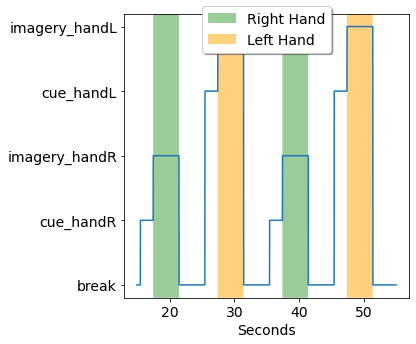

In [100]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}
plt.rcParams.update({'font.size': 14})

visualise.plot_events(
    eeg_timestamps,
    event_timeseries,
    fs,
    label2code,
    window=40
)



# Preprocess EEG data

## 1. Rereference the EEG data

In [101]:
# Rereference according to the mean
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## 2. Filter EEG data

In [102]:
lf = 8
hf = 16
nf = 50

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='butter')

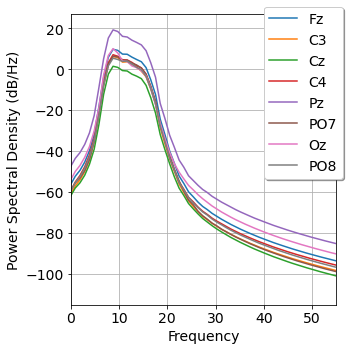

In [103]:
plt.figure(figsize=(5,5))
# plt.title(f'Filtering on all channels from {lf}-{hf} Hz')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.05), shadow=True, fancybox=True)
plt.xlim([0,55])
plt.ylim([-115,27])
plt.show()

## 3. Normalise EEG data

In [104]:
eeg_notched_bp_norm = preprocess.normalise_eeg(eeg_notched_bp)

# Inspect EEG data with markers

In [105]:
# visualise.plot_all(
#     eeg_timestamps=eeg_timestamps, 
#     event_time_series=event_timeseries, 
#     eeg_data=eeg_notched_bp_norm, 
#     event_labels=event_labels,
#     fs=fs,
#     start_time=44,
#     window=10
# )

# Split into trials

In [106]:
EEG = eeg_notched_bp_norm.copy()
event_onsets = event_timestamps.copy()
classes = ['imagery_handL', 'imagery_handR']
class_codes = [label2code[code] for code in classes]
nclasses = len(classes)
nchannels = EEG.shape[0]

# Print some information
print('Sample rate:', fs)
print('Number of EEG channels:', nchannels)
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])

print('\nNumber of classes:', nclasses)
print('Class labels:', classes)

print('\nNumber of events:', len(event_onsets))
print('All event codes:', np.unique(event_codes))
print('Class codes:', class_codes)

Sample rate: 250
Number of EEG channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

Number of classes: 2
Class labels: ['imagery_handL', 'imagery_handR']

Number of events: 1213
All event codes: [0 1 2 3 4 5 6 7]
Class codes: [7, 5]


In [107]:
mi_window = [0.5, 2.5]
mi_nsamples = len(np.arange(int(mi_window[0]*fs), int(mi_window[1]*fs)))

idle_window = [0.25, 1.75]
idle_nsamples = len(np.arange(int(idle_window[0]*fs), int(idle_window[1]*fs)))

class_nsamples = [mi_nsamples, mi_nsamples]

trials = get_trials(
    eeg_data=EEG,
    event_time_series=event_timeseries,
    class_labels=classes,
    label2code=label2code,
    nsamples=class_nsamples
)

for key, val in trials.items():
    print(f'{key}: {val.shape}')

imagery_handL: (8, 500, 200)
imagery_handR: (8, 500, 200)


# Some statistical Analysis to remove noisy trials

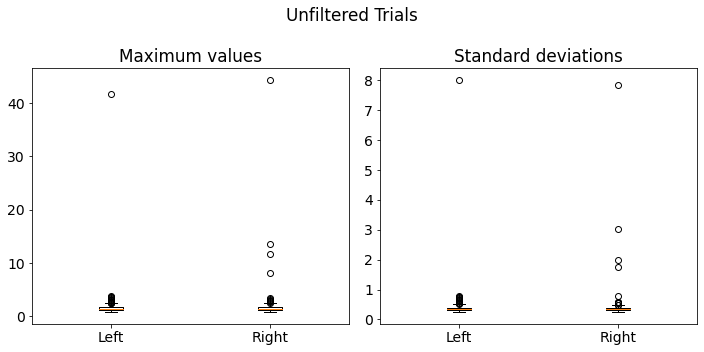

In [108]:
nice_labels = ['Left', 'Right']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Unfiltered Trials')

axs[0].set_title('Maximum values')
axs[0].boxplot([ trials[cl].max(axis = (0,1)) for cl in classes ], labels=nice_labels)

axs[1].set_title('Standard deviations')
axs[1].boxplot([ trials[cl].std(axis = (0,1)) for cl in classes ], labels=nice_labels)

plt.tight_layout()
plt.show()

In [109]:
# Set the upper limit on the maxval and std dev as 2*(3rd quartile)

upperlimit_max = {}
for cl in classes:
    upperlimit_max[cl] = np.percentile(trials[cl].max(axis = (0,1)), [75])[0] * 1.5

upperlimit_std = {}
for cl in classes:
    upperlimit_std[cl] = np.percentile(trials[cl].std(axis = (0,1)), [75])[0] * 1.5

upperlimit_std

{'imagery_handL': 0.5966861295360828, 'imagery_handR': 0.5607748092425172}

In [110]:
good_trials = get_good_trials(
    trials=trials,
    nchannels=nchannels,
    class_nsamples=class_nsamples,
    upperlimit_std=upperlimit_std,
    upperlimit_max=upperlimit_max
)

for cl in classes:
    print(f'{cl} has {good_trials[cl].shape} non noisy trials')


imagery_handL has (8, 500, 187) non noisy trials
imagery_handR has (8, 500, 190) non noisy trials


In [111]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle('Unfiltered Trials')

# axs[0].set_title('Maximum values')
# axs[0].boxplot([ good_trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

# axs[1].set_title('Standard deviations')
# axs[1].boxplot([ good_trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

# plt.tight_layout()
# plt.show()

In [112]:
from matplotlib_scalebar.scalebar import ScaleBar

In [113]:
# nice_labels = ['Left', 'Right']

# fig, axs = plt.subplots(2, 2, figsize=(6, 8), sharex=True)
# # fig.suptitle('Unfiltered Trials')

# axs[0,0].set_title('Maximum value')
# axs[0,0].set_ylabel('All Trials')
# # axs[0,0].set_yticks([])
# axs[0,0].boxplot([ trials[cl].max(axis = (0,1)) for cl in classes ], labels=nice_labels, widths=0.8)

# axs[0,1].set_title('Standard deviation')
# # axs[0,1].set_yticks([])
# axs[0,1].boxplot([ trials[cl].std(axis = (0,1)) for cl in classes ], labels=nice_labels, widths=0.8)

# # axs[1,0].set_title('Maximum values')
# axs[1,0].set_ylabel('Selected Trials')
# # axs[1,0].set_yticks([])
# axs[1,0].boxplot([ good_trials[cl].max(axis = (0,1)) for cl in classes ], labels=nice_labels, widths=0.8)

# # axs[1,1].set_title('Standard deviations')
# # axs[1,1].set_yticks([])
# axs[1,1].boxplot([ good_trials[cl].std(axis = (0,1)) for cl in classes ], labels=nice_labels, widths=0.8)

# plt.tight_layout()
# plt.show()

# Analysis

In [114]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', EEG.shape[0])
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', classes)
print('Class codes:', class_codes)
print('Number of classes:', nclasses)

cl0 = classes[0]
cl1 = classes[1]

Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
Number of events: 1213
Event codes: [0 1 2 3 4 5 6 7]
Class labels: ['imagery_handL', 'imagery_handR']
Class codes: [7, 5]
Number of classes: 2


In [115]:
# trials_PSD = {}
# for cl in classes:
#     psd, freqs, = analysis.psd(good_trials[cl], nchannels, class_nsamples[0], fs)
#     trials_PSD[cl] = psd

# analysis.plot_psd(
#     trials_PSD,
#     freqs,
#     [preprocess.name2channel(name) for name in ['C3', 'Cz', 'C4']],
#     chan_lab=['C3', 'Cz', 'C4'],
#     maxy=0.05,   #0.05 for normalised data and 1 for not normalised
#     pretty_labels=['Left', 'Right']
# )

In [116]:
# trials_bp = {}
# for cl in classes:
#     freqs, bandpower = analysis.bandpower(good_trials[cl], fs, band=[10, 12])
#     trials_bp[cl] = bandpower

# analysis.plot_bandpower(trials_bp, classes)

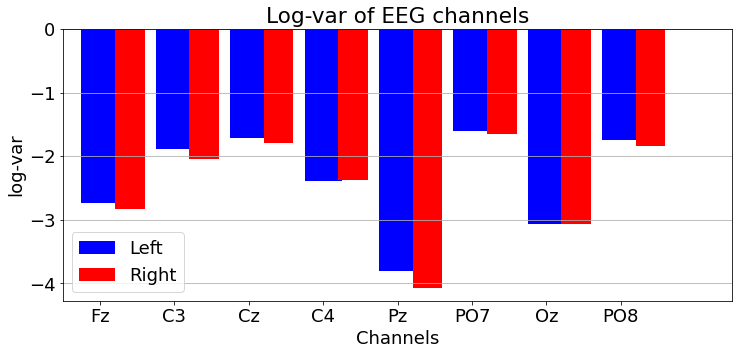

In [131]:
trials_logvar = {}
for cl in classes:
    trials_logvar[cl] = analysis.logvar(good_trials[cl])


analysis.plot_logvar(
    trials_logvar, 
    classes, 
    title='Log-var of EEG channels', 
    data_type="EEG",
    pretty_labels=['Left', 'Right'])

### CSP
Using CSP generates components which are easier to classify than the channels. 

Instead of 8 channels, we now have 8 mixtures of channels, called components. They are the result of 8 spatial filters applied to the data.

The first filters maximize the variation of the first class, while minimizing the variation of the second. The last filters maximize the variation of the second class, while minimizing the variation of the first.

This is also visible in a PSD plot.

Shape for class imagery_handL after csp: (8, 500, 187)
Shape for class imagery_handR after csp: (8, 500, 190)
Shape for class imagery_handL after logvar: (8, 187)
Shape for class imagery_handR after logvar: (8, 190)


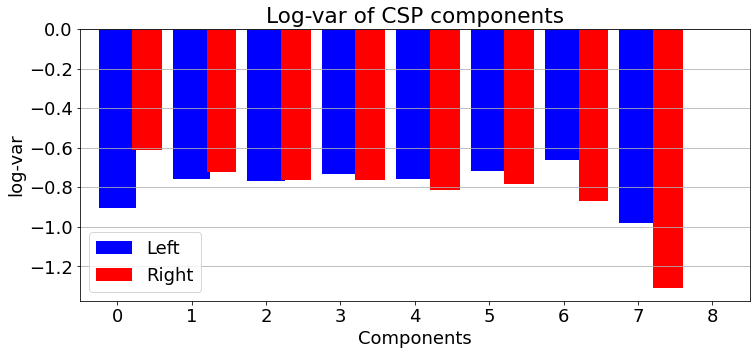

In [132]:
csp = preprocess.CSP(good_trials, classes, class_nsamples[0], nchannels)
trials_csp = csp.get_csp_trials()

for cl in classes:
    print(f'Shape for class {cl} after csp: {trials_csp[cl].shape}')

trials_csp_logvar = {}
for cl in classes:
    trials_csp_logvar[cl] = analysis.logvar(trials_csp[cl])
    print(f'Shape for class {cl} after logvar: {trials_csp_logvar[cl].shape}')

analysis.plot_logvar(trials_csp_logvar, classes,
    title='Log-var of CSP components', 
    pretty_labels=['Left', 'Right'])

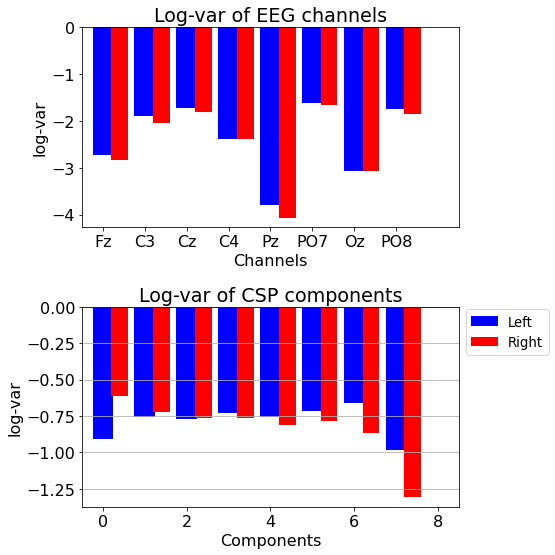

In [171]:
nchannels = trials_csp_logvar[classes[0]].shape[0]

plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(2,1, figsize=(8,8))

x0 = np.arange(nchannels)
x1 = np.arange(nchannels) + 0.4
y0 = np.mean(trials_logvar[classes[0]], axis=1)
y1 = np.mean(trials_logvar[classes[1]], axis=1)


axs[0].bar(x0, y0, width=0.5, color='b')
axs[0].bar(x1, y1, width=0.4, color='r')

axs[0].set_xlim(-0.5, nchannels+0.5)
axs[0].set_ylabel('log-var')
plt.gca().yaxis.grid(True)

title = 'Log-var of EEG channels'
axs[0].set_title(title)

axs[0].set_xlabel('Channels')
axs[0].set_xticks(list(x0))
axs[0].set_xticklabels(['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'])

x0 = np.arange(nchannels)
x1 = np.arange(nchannels) + 0.4
y0 = np.mean(trials_csp_logvar[classes[0]], axis=1)
y1 = np.mean(trials_csp_logvar[classes[1]], axis=1)


axs[1].bar(x0, y0, width=0.5, color='b')
axs[1].bar(x1, y1, width=0.4, color='r')

axs[1].set_xlim(-0.5, nchannels+0.5)

plt.gca().yaxis.grid(True)

title = 'Log-var of CSP components'
axs[1].set_title(title)
axs[1].set_xlabel('Components')
axs[1].set_ylabel('log-var')

pretty_labels = ['Left', 'Right']
plt.legend(pretty_labels, bbox_to_anchor=(1, 1.02), fontsize='small')
plt.tight_layout()
plt.show()

In [164]:
list(x0), ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

([0, 1, 2, 3, 4, 5, 6, 7], ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'])

In [119]:
# band = [10,12]
# trials_bp = {}
# for cl in classes:
#     freqs, bandpower = analysis.bandpower(trials_csp[cl], fs)
#     trials_bp[cl] = bandpower

# analysis.plot_bandpower(trials_bp, classes)

In [120]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# for cl, col in zip(classes, ['b', 'r']):
#     ax.scatter(trials_bp[cl][0,:], trials_bp[cl][-1,:], color=col)

# ax.set_xlim([-0.1, 0.3])
# ax.set_ylim([-0.1, 0.4])
# ax.set_aspect('equal')
# plt.show()

In [121]:
# trials_csp_PSD = {}
# for cl in classes:
#     psd, freqs, = analysis.psd(trials_csp[cl], nchannels, class_nsamples[0], fs)
#     trials_csp_PSD[cl] = psd

# analysis.plot_psd(
#     trials_csp_PSD,
#     freqs,
#     [0,3,-1],
#     chan_lab=['first component', 'middle component', 'last component'],
#     maxy=0.22,
#     pretty_labels=['Left', 'Right']
# )

In [122]:
# import matplotlib.transforms as mtransforms

In [123]:
# fig, axs = plt.subplots(2,3,sharex=True, figsize=(6,6))

# labels=['Left', 'Right']
# eeg_channels = ['C3', 'Cz', 'C4']
# for i, ch in enumerate(eeg_channels):
#     cd_idx = preprocess.name2channel(ch)
#     for j, cl in enumerate(classes):
#         axs[0,i].plot(
#             freqs, np.mean(trials_PSD[cl][cd_idx,:,:], axis=1), label=labels[j])
    
#     diff = np.abs(
#         np.mean(trials_PSD[classes[0]][cd_idx,:,:], axis=1) - 
#         np.mean(trials_PSD[classes[1]][cd_idx,:,:], axis=1))
#     axs[0,i].vlines(freqs[diff.argmax()], 0, 0.005, 'r', label=r'|L - R|$_{max}$')
    
#     axs[0,i].set_xlim(5,20)
#     axs[0,i].set_ylim(0,0.05)
#     axs[0,i].grid()
#     axs[0,i].set_title(ch)
#     if i > 0:
#         axs[0,i].set_yticks([])

#     trans = mtransforms.blended_transform_factory(
#                 axs[0,i].transData, 
#                 axs[0,i].transAxes)
#     axs[0,i].fill_between(
#                 freqs, 0, 1, where=np.logical_and(freqs > 8, freqs < 16),
#                 facecolor='green', alpha=0.2, transform=trans, label=r'$\alpha$ Band')


# # axs[0,i].legend(loc='upper right', bbox_to_anchor=(1, 1.35), shadow=True, fontsize='small')

# for i, ch in enumerate(csp_components):

#     for j, cl in enumerate(classes):
#         axs[1,i].plot(
#             freqs, 
#             np.mean(trials_csp_PSD[cl][ch,:,:], axis=1), label=labels[j])
    
#     diff = np.abs(
#         np.mean(trials_csp_PSD[classes[0]][ch,:,:], axis=1) - 
#         np.mean(trials_csp_PSD[classes[1]][ch,:,:], axis=1))
#     axs[1,i].vlines(freqs[diff.argmax()], 0, 0.02, 'r', label=r'|L - R|$_{max}$')
    
#     axs[1,i].set_xlim(5,20)
#     axs[1,i].set_ylim(0,0.22)
#     axs[1,i].grid()
#     axs[1,i].set_title(csp_components_lab[i])

#     if i > 0:
#         axs[1,i].set_yticks([])

#     trans = mtransforms.blended_transform_factory(
#                 axs[1,i].transData, 
#                 axs[1,i].transAxes)
#     axs[1,i].fill_between(
#                 freqs, 0, 1, where=np.logical_and(freqs > 8, freqs < 16),
#                 facecolor='green', alpha=0.2, transform=trans, label=r'$\alpha$ Band')

# axs[1,1].set_xlabel('Frequency (Hz)')

# handles, labels = axs[1,1].get_legend_handles_labels()
# fig.legend(handles, labels, bbox_to_anchor=(0.3, 1.02, .7, .102), loc='lower left',
#            ncol=2, mode="expand", shadow=True,)

# plt.tight_layout()
# plt.show()


## LDA

In [124]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.svm import SVC as skSVM
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as skQDA
from sklearn.neural_network import MLPClassifier as skMLP
from sklearn.metrics import confusion_matrix

In [125]:
# H-PARAMS
nfolds = 5                              # Number of folds
components = np.array([0,-1])           # Select components as features for classification
feature = 'logvar'
band = [11, 12.7]

classifier = skLDA()
# classifier = skSVM(gamma='auto', kernel='linear')
# classifier = skQDA()
# classifier = skMLP(random_state=1, max_iter=500, )

assert feature in ['bandpower', 'logvar']

In [126]:
# Find size of cross val datasets
test_set_shapes = {}
train_set_shapes = {}
for cl in classes:
    test_set_shapes[cl] = int(good_trials[cl].shape[2] / nfolds)
    train_set_shapes[cl] = good_trials[cl].shape[2] - test_set_shapes[cl]


# Places to save the results
accuracies = {}
confusion_matrices = {}

# Run cross validation for k folds
for i in range(nfolds):    
    train = {}
    test = {}

    # Create train-test split
    for cl in classes:
        ntest = test_set_shapes[cl]
        train[cl] = np.concatenate(
            [good_trials[cl][:,:,:i*ntest], 
            good_trials[cl][:,:,(i+1)*ntest:]], axis=2)
        
        test[cl] = good_trials[cl][:,:,i*ntest:(i+1)*ntest]

    # CSP
    train_csp = preprocess.CSP(train, classes, class_nsamples[0], nchannels)
    train = train_csp.get_csp_trials()
    W = train_csp.get_W()
    test_csp = preprocess.CSP(test, classes, class_nsamples[0], nchannels, W=W)
    test = test_csp.get_csp_trials()

    # Select CSP components
    for cl in classes:
        train[cl] = train[cl][components,:,:]
        test[cl] = test[cl][components,:,:]

    # Feature extraction
    if feature == 'bandpower':
        # Bandpower
        for cl in classes:
            _, bandpower = analysis.bandpower(train[cl], fs, band)
            train[cl] = bandpower
            _, bandpower = analysis.bandpower(test[cl], fs, band)
            test[cl] = bandpower
    elif feature == 'logvar':
        # Logvar
        for cl in classes:
            train[cl] = analysis.logvar(train[cl])
            test[cl] = analysis.logvar(test[cl])
    
    # Build sk-learn compatible matrices
    X_train = np.concatenate([
        train[classes[0]], 
        train[classes[1]]], axis=1).T
    
    y_train = np.concatenate([
        np.zeros(train[classes[0]].shape[1]), 
        np.ones(train[classes[1]].shape[1])], axis=0)
    
    X_test = np.concatenate([
        test[classes[0]], 
        test[classes[1]]], axis=1).T
    
    y_test = np.concatenate([
        np.zeros(test[classes[0]].shape[1]), 
        np.ones(test[classes[1]].shape[1])], axis=0)
    
    # LDA classifier
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    confusion_matrices[i] = confusion_matrix(y_test, y_pred)
    accuracies[i] = np.sum(y_pred == y_test) / y_pred.size

In [127]:
visualise.print_results(classes, accuracies, confusion_matrices)

Accuracy	True imagery_handL	False imagery_handL	False imagery_handR	True imagery_handR
--------------------------------------------------------------------------------------------------------------
0.56			20			16			17			22
0.72			23			7			14			31
0.60			24			17			13			21
0.72			29			13			8			25
0.80			27			5			10			33
--------------------------------------------------------------------------------------------------------------
0.68			24.6			12.4			11.6			26.4
--------------------------------------------------------------------------------------------------------------


In [128]:
visualise.print_results(classes, accuracies, confusion_matrices, format='tex')

&Accuracy	& True imagery_handL	& False imagery_handL	& False imagery_handR	& True imagery_handR \\
Fold 0 & 0.56		& 20		& 17		& 16		& 22 \\
Fold 1 & 0.72		& 23		& 14		& 7		& 31 \\
Fold 2 & 0.60		& 24		& 13		& 17		& 21 \\
Fold 3 & 0.72		& 29		& 8		& 13		& 25 \\
Fold 4 & 0.80		& 27		& 10		& 5		& 33 \\
Average &0.68		& 24.6		& 12.4		& 11.6		& 26.4 \\


In [129]:
confusion_matrices[i]

array([[27, 10],
       [ 5, 33]])

In [130]:
print(f'Number of gt left: {np.sum(y_test == 0)}')
print(f'Number of gt right: {np.sum(y_test == 1)}')

Number of gt left: 37
Number of gt right: 38
